In [51]:
 %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [52]:
import numpy as np
import pandas as pd

In [53]:
import datetime as dt

In [62]:
 # Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [80]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [81]:
 # reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [83]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [85]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [86]:
# Create our session (link) from Python to the DB
session = Session(engine) 

In [88]:
#Finding the earliest date in the data
earlieststr = session.query(Measurement.date).order_by(Measurement.date).first()
#Finding the last date in the data
lateststr = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Earliest: {earlieststr[0]} , Latest: {lateststr[0]}")

Earliest: 2010-01-01 , Latest: 2017-08-23


In [94]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


#Removing the time element from the date
latestdate = dt.datetime.strptime(lateststr[0], '%Y-%m-%d')
# Calculate the date 1 year ago from the last data point in the database
querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
querydate

#Create columns to pull into list
sel = [Measurement.date,Measurement.prcp]
#Query the results to get dates and precipitation scores
queryresult = session.query(*sel).filter(Measurement.date >= querydate).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation = pd.DataFrame(queryresult, columns=['Date','Precipitation'])
# clean up non value entries
precipitation = precipitation.dropna(how='any')
#Sort the dataframe by date
precipitation = precipitation.sort_values(["Date"], ascending=True)
#set the index to the date column
precipitation = precipitation.set_index("Date")
precipitation.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


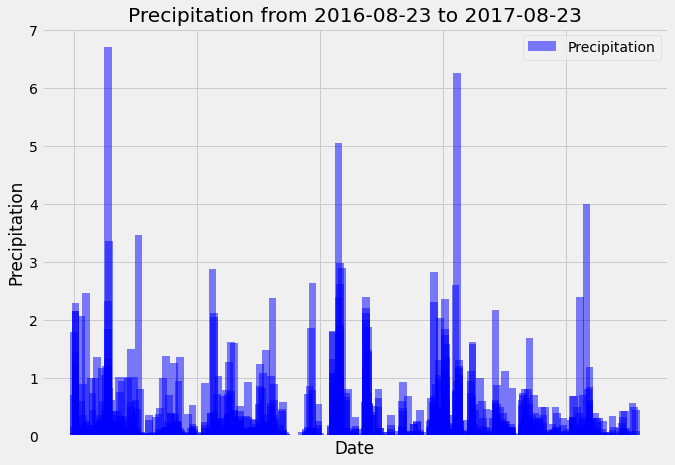

In [92]:
# Use Pandas Plotting with Matplotlib to plot the data
xx = precipitation.index.tolist()
yy = precipitation['Precipitation'].tolist()

plt.figure(figsize=(10,7))
plt.bar(xx,yy,width = 5 ,color='b', alpha=0.5, align="center",label='Precipitation')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"Precipitation from {querydate} to {lateststr[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()

In [90]:
# Use Pandas to calcualte the summary statistics for the precipitation data 
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [96]:
# Design a query to show how many stations are available in this dataset?
#Simple count of the sation id's
session.query(Station.id).count()

9

In [97]:
# What are the most active stations? (i.e. what stations have the most rows)?
#Created a list based on count of measurements
sel = [Measurement.station,func.count(Measurement.id)]
# List the stations and the counts in descending order.
active_stations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [103]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
most_active_station_data = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
most_active_station_data

(54.0, 85.0, 71.66378066378067)

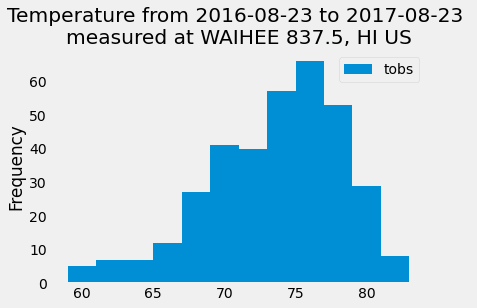

In [109]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#filtering on  first active station after sorting
queryresult = session.query(Measurement.tobs).\
    filter(Measurement.station == active_stations[0][0]).\
    filter(Measurement.date >= querydate).all()
#Turning the above array into a list
temperatures = list(np.ravel(queryresult))

#Creating the selection criteria
sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
#quering the data
queryresult = session.query(*sel).all()
#turn the query results into a DataFrame
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])
#Pullling the station names into a list
station_name = stations_desc.loc[stations_desc["Station"] == active_stations[0][0],"Name"].tolist()[0]
#plotting histogram
plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both')
plt.ylabel('Frequency')
plt.title(f"Temperature from {querydate} to {lateststr[0]} \nmeasured at {station_name}")
plt.legend()